# Import modules + define routines & EPICS channels

In [2]:
%matplotlib nbagg
import numpy as np
import json
import h5py
import matplotlib.pyplot as plt
import scipy
from scipy.special import erf
from scipy.optimize import curve_fit
import os

In [3]:
def LoadData_knife_edge(filename):
    with h5py.File(filename, 'r') as BS_file:
        pulse_ids = BS_file[channel_pulse_ids][:]
        reprate_FEL = ((pulse_ids%4 == 0) & (pulse_ids%8 != 0))                #This is for 25 Hz
        reprate_laser = pulse_ids%8 == 0                                       #This is for 12.5 Hz
        
        Data_pumped = BS_file[channel_PIPS_fluo][:][reprate_laser]
        Data_unpumped = BS_file[channel_PIPS_fluo][:][reprate_FEL]
        
        DataT_pumped = BS_file[channel_PIPS_trans][:][reprate_laser]
        DataT_unpumped = BS_file[channel_PIPS_trans][:][reprate_FEL]
        
        Izero_pump = BS_file[channel_Izero][:][reprate_laser]
        Izero_unpump = BS_file[channel_Izero][:][reprate_FEL]
        
        Energy = BS_file[channel_energy][:][reprate_FEL]
        Position = BS_file[channel_position][:][reprate_FEL]
        #Position = BS_file[channel_laser_pitch][:][reprate_FEL]
        Palm = BS_file[channel_palm_analysis][:][reprate_FEL]
        
    return Data_pumped, Data_unpumped, Izero_pump, Izero_unpump, Energy, Position, DataT_pumped, DataT_unpumped, Palm

def errfunc(x, a, b, c, d):
    return a + b*erf((c-x)*np.sqrt(np.log(2))/(np.abs(d)))

def biexp(x, baseline, amplitude, t0, width, a1, t1, a2, t2):
    return baseline + amplitude*(1-erf((t0-x)*np.sqrt(np.log(2))/(np.abs(width))))*(a1*np.exp(-x/t1)+a2*np.exp(-x/t2))

In [4]:
# only through raw and JF

channel_PIPS_trans = "data/SARES11-GES1:CH1_VAL_GET/data"           #X-ray diode to PRIME Keysight
channel_PIPS_fluo = "data/SARES11-GES1:CH2_VAL_GET/data"           #X-ray diode to PRIME Keysight
channel_Izero = "data/SARES11-LSCP10-FNS:CH2:VAL_GET/data"          #Izero diode to PRIME Ioxos (channel 3)
channel_Izero2 = "data/SARES11-LSCP10-FNS:CH3:VAL_GET/data"          #Izero diode to PRIME Ioxos (channel 0)
channel_Izero3 = "data/SARES11-LSCP10-FNS:CH1:VAL_GET/data"          #Izero diode to PRIME Ioxos (channel 1)
channel_Izero4 = "data/SARES11-LSCP10-FNS:CH2:VAL_GET/data"         #Izero diode to PRIME Ioxos (channel 2)
channel_LaserDiode = "data/SLAAR11-LSCP1-FNS:CH0:VAL_GET/data"      #Laser diode to ESA Laser Ioxos 
channel_Laser_refDiode = "data/SLAAR11-LSCP1-FNS:CH2:VAL_GET/data"  #Laser diode leaking from beampath, to ESA Laser Ioxos 
#channel_LaserDiode = "SARES11-GES1:CH2_VAL_GET/data"          #Laser diode to PRIME Keysight
channel_pulse_ids = "data/SLAAR11-LMOT-M451:ENC_1_BS/pulse_id"      #Pulse ids taken from pump-probe delay stage (100 Hz)
channel_delay = "data/SLAAR11-LMOT-M451:ENC_1_BS/data"              #Delay of pump-probe delay stage
channel_LAM_delaystage = "data/SLAAR11-LTIM01-EVR0:DUMMY_PV2_NBS/data"       #LAM internal stage position in mm
channel_LAM_stepper = "data/SLAAR11-LTIM01-EVR0:DUMMY_PV10_NBS/data"         #LAM stepper motor (used for feedback)
channel_waveplate= "data/SLAAR11-LTIM01-EVR0:DUMMY_PV8_NBS/data"         #LAM stepper motor (used for feedback)
channel_PALM_eTOF = "data/SAROP11-PALMK118:CH2_BUFFER/data"                 #PALM eTof from Ch2

#Position of the stage: Dummy PV1 for x axis, dummy PV3 for y axis
channel_position = "data/SLAAR11-LTIM01-EVR0:DUMMY_PV1_NBS/data"     #Huber stage X position. 
channel_position = "data/SLAAR11-LMOT-M451:ENC_1_BS/data"
channel_energy = "data/SLAAR11-LTIM01-EVR0:DUMMY_PV3_NBS/data"       #Energy from the monochromator
channel_laser_yaw= "data/SLAAR11-LTIM01-EVR0:DUMMY_PV2_NBS/data"
channel_laser_pitch= "data/SLAAR11-LTIM01-EVR0:DUMMY_PV4_NBS/data"
channel_palm_analysis= "data/SAROP11-PALMK118:ANALYSIS_PALM_DEL/data"     # Palm analysis probably fs ????


In [82]:
# #For BS local

# channel_PIPS_trans = "SARES11-GES1:CH1_VAL_GET/data"           #X-ray diode to PRIME Keysight
# channel_PIPS_fluo = "SARES11-GES1:CH2_VAL_GET/data"           #X-ray diode to PRIME Keysight
# channel_Izero = "SARES11-LSCP10-FNS:CH2:VAL_GET/data"          #Izero diode to PRIME Ioxos (channel 3)
# channel_Izero2 = "SARES11-LSCP10-FNS:CH3:VAL_GET/data"          #Izero diode to PRIME Ioxos (channel 0)
# channel_Izero3 = "SARES11-LSCP10-FNS:CH1:VAL_GET/data"          #Izero diode to PRIME Ioxos (channel 1)
# channel_Izero4 = "SARES11-LSCP10-FNS:CH2:VAL_GET/data"         #Izero diode to PRIME Ioxos (channel 2)
# channel_LaserDiode = "SLAAR11-LSCP1-FNS:CH0:VAL_GET/data"      #Laser diode to ESA Laser Ioxos 
# channel_Laser_refDiode = "SLAAR11-LSCP1-FNS:CH2:VAL_GET/data"  #Laser diode leaking from beampath, to ESA Laser Ioxos 
# #channel_LaserDiode = "SARES11-GES1:CH2_VAL_GET/data"          #Laser diode to PRIME Keysight
# channel_pulse_ids = "SLAAR11-LMOT-M451:ENC_1_BS/pulse_id"      #Pulse ids taken from pump-probe delay stage (100 Hz)
# channel_delay = "SLAAR11-LMOT-M451:ENC_1_BS/data"              #Delay of pump-probe delay stage
# channel_LAM_delaystage = "SLAAR11-LTIM01-EVR0:DUMMY_PV2_NBS/data"       #LAM internal stage position in mm
# channel_LAM_stepper = "SLAAR11-LTIM01-EVR0:DUMMY_PV10_NBS/data"         #LAM stepper motor (used for feedback)
# channel_waveplate= "SLAAR11-LTIM01-EVR0:DUMMY_PV8_NBS/data"         #LAM stepper motor (used for feedback)
# channel_PALM_eTOF = "SAROP11-PALMK118:CH2_BUFFER/data"                 #PALM eTof from Ch2

# #Position of the stage: Dummy PV1 for x axis, dummy PV3 for y axis
# channel_position = "SLAAR11-LTIM01-EVR0:DUMMY_PV1_NBS/data"     #Huber stage X position. 
# channel_position = "SLAAR11-LMOT-M451:ENC_1_BS/data"
# channel_energy = "SLAAR11-LTIM01-EVR0:DUMMY_PV3_NBS/data"       #Energy from the monochromator
# channel_laser_yaw= "SLAAR11-LTIM01-EVR0:DUMMY_PV2_NBS/data"
# channel_laser_pitch= "SLAAR11-LTIM01-EVR0:DUMMY_PV4_NBS/data"
# channel_palm_analysis= "data/SAROP11-PALMK118:ANALYSIS_PALM_DEL/data"     # Palm analysis probably fs ????


# Scan name

In [5]:
scan_name ="CytC_Fe3_timescan_7p5uJ_350nm_7122eV_021"
#scan_name ="CytC_Fe3_monoscan_350nm_5uJ_500fs_005"
# file names of the type below. copy paste for ease:
# FEL_knife_edge_Y_coarse_

# FEL_knife_edge_X_coarse_
# FEL_knife_edge_Y_fine_
# FEL_knife_edge_X_fine_

DIR = "/sf/alvra/data/p17803/raw/scan_data/" + scan_name + "/"
DIR_json = "/sf/alvra/data/p17803/res/scan_info/"

In [84]:
# #scan_name ="CytC_Fe3_timescan_5uJ_288nm_7122eV_006"
# #scan_name ="CytC_Fe3_timescan_5uJ_288nm_7122eV_004"
# scan_name ="CytC_Fe3_monoscan_350nm_5uJ_500fs_004"
# # file names of the type below. copy paste for ease:
# # FEL_knife_edge_Y_coarse_
# # FEL_knife_edge_X_coarse_
# # FEL_knife_edge_Y_fine_
# # FEL_knife_edge_X_fine_

# DIR = "/sf/alvra/data/p17803/raw/"
# DIR_json = "/sf/alvra/data/p17803/res/scan_info/"

# Load one step and filter some data from I0

In [6]:
f = "CytC_Fe3_timescan_7p5uJ_350nm_7122eV_021_step0015.BSREAD.h5"
#f = "CytC_Fe3_monoscan_288nm_5uJ_500fs_009_step0015.BSREAD.h5"
#f = "test_laser_scatter_PBPS.BSREAD.h5"
filename = DIR + f

(signal_pump_loop,signal_unpump_loop,Izero_pump_loop, Izero_unpump_loop,energy_loop,position_loop,\
         signalT_pump_loop,signalT_unpump_loop, palm_loop) = LoadData_knife_edge(filename)

Izero_pump_original = Izero_pump_loop.copy()
Izero_unpump_original = Izero_unpump_loop.copy()
#Izero_pump_loop = [x for x in Izero_pump_loop if (np.abs(x) > 1000)]
print (np.median(Izero_pump_loop)-1.25*(np.std(Izero_pump_loop)))
conditionPumpMax = Izero_pump_loop < np.median(Izero_pump_loop)+1.2*(np.std(Izero_pump_loop))
conditionPumpMin = Izero_pump_loop > np.median(Izero_pump_loop)-1.2*(np.std(Izero_pump_loop))

conditionUnPumpMax = Izero_unpump_loop < np.median(Izero_unpump_loop)+1.2*(np.std(Izero_unpump_loop))
conditionUnPumpMin = Izero_unpump_loop > np.median(Izero_unpump_loop)-1.2*(np.std(Izero_unpump_loop))

conditionGeneral = Izero_pump_loop > 1000
conditionGeneral2 = Izero_unpump_loop > 1000

Izero_pump_loop = Izero_pump_loop[conditionPumpMin & conditionPumpMax & conditionUnPumpMin & conditionUnPumpMax & conditionGeneral & conditionGeneral2]

#Izero_pump_loop = [x for x in Izero_unpump_loop if (np.abs(x) > 1000)]

Izero_pump_loop = np.asarray(Izero_pump_loop)
Izero_pump_original = np.asarray(Izero_pump_original)



212.34056818172735


<IPython.core.display.Javascript object>


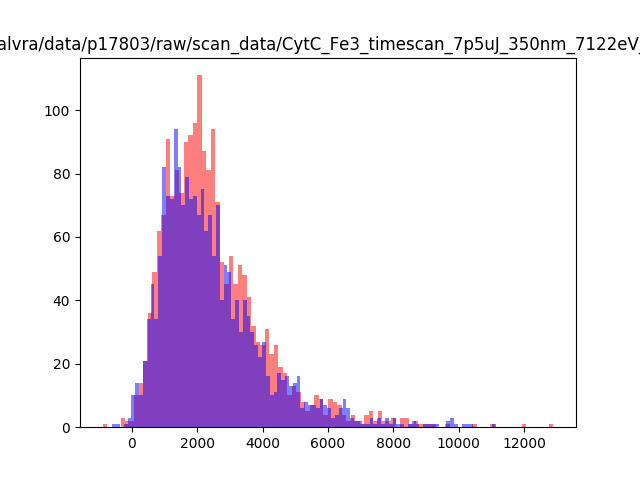

In [7]:
num_bins = 100
plt.figure()
#plt.hist(Izero_pump_loop, num_bins, facecolor='blue', alpha=0.5)
plt.hist(Izero_pump_original, num_bins, facecolor='red', alpha=0.5)
plt.hist(Izero_unpump_original, num_bins, facecolor='blue', alpha=0.5)

plt.title(DIR)


plt.show()

2504.3788514851485 2460.6566237623765


<IPython.core.display.Javascript object>


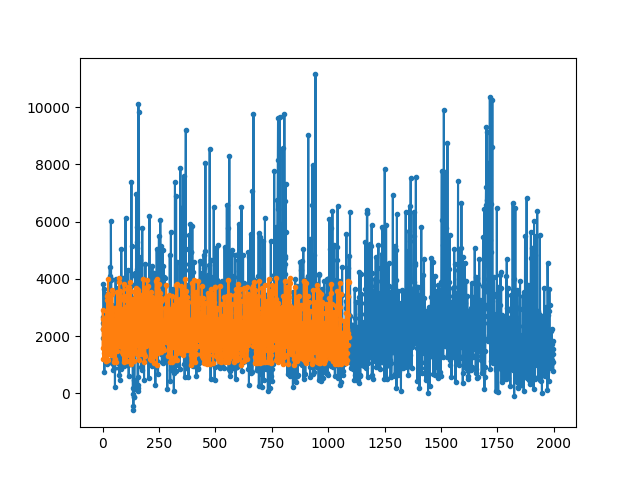

In [8]:
#print (Izero_pump_loop.size, Izero_pump_original.size)
print (Izero_pump_original.mean(), Izero_unpump_original.mean())

plt.figure()

#plt.plot(Izero_pump_original, label="original",marker='.')
plt.plot(Izero_unpump_loop, label="Izero_pump",marker='.')
plt.plot(Izero_pump_loop, label="Izero_pump",marker='.')


# Analyse full run

In [9]:
!ls -lah -rt $DIR
!hostname

listfile = os.listdir(DIR)
number_files = len(listfile)
print ("There are",number_files,"files in the folder", DIR)

total 1.9T
drwxrwsr-x. 118 root p17803  32K Jan 27 22:25 ..
-rw-r--r--.   1 root p17803  36G Jan 27 22:28 CytC_Fe3_timescan_7p5uJ_350nm_7122eV_021_step0000.JF02T09V01.h5
-rw-r--r--.   1 root p17803 9.2M Jan 27 22:28 CytC_Fe3_timescan_7p5uJ_350nm_7122eV_021_step0000.BSREAD_CA.h5
-rw-r--r--.   1 root p17803 1.7G Jan 27 22:30 CytC_Fe3_timescan_7p5uJ_350nm_7122eV_021_step0000.BSREAD.h5
-rw-r--r--.   1 root p17803  36G Jan 27 22:30 CytC_Fe3_timescan_7p5uJ_350nm_7122eV_021_step0001.JF02T09V01.h5
-rw-r--r--.   1 root p17803  12M Jan 27 22:31 CytC_Fe3_timescan_7p5uJ_350nm_7122eV_021_step0001.BSREAD_CA.h5
-rw-r--r--.   1 root p17803 1.7G Jan 27 22:33 CytC_Fe3_timescan_7p5uJ_350nm_7122eV_021_step0001.BSREAD.h5
-rw-r--r--.   1 root p17803  36G Jan 27 22:33 CytC_Fe3_timescan_7p5uJ_350nm_7122eV_021_step0002.JF02T09V01.h5
-rw-r--r--.   1 root p17803  12M Jan 27 22:34 CytC_Fe3_timescan_7p5uJ_350nm_7122eV_021_step0002.BSREAD_CA.h5
-rw-r--r--.   1 root p17803 1.7G Jan 27 22:35 CytC_Fe3_timescan_7p5uJ_3

ra-c-004.psi.ch
There are 153 files in the folder /sf/alvra/data/p17803/raw/scan_data/CytC_Fe3_timescan_7p5uJ_350nm_7122eV_021/


In [10]:
json_file = DIR_json + scan_name + "_scan_info.json"
print (json_file)

with open(json_file) as file:
    data = json.load(file)
numFiles = len(data['scan_files'])
# numFiles = 39

print ("Processing",numFiles,"files")

Signal_pump = []
Signal_unpump = []
Signal_diff = []
err_signal_pump = []
err_signal_unpump = []
err_signal_diff = []

SignalT_pump = []
SignalT_unpump = []
err_signalT_pump = []

Izero_pump_check = []
Izero_unpump_check = []
err_Izero = []
Izero_loop = []

Position_mm = []
Energy_eV = []

Palm_fs = []


# from itertools import chain
# concatenated = chain(range(0,37), range(43, 50))
# for i in concatenated:
for i in range(0,numFiles):             
    filename = str(data['scan_files'][i][0])    
    exists = os.path.isfile(filename)
    if exists: # and i!=39:
        print("step",i+1,"of",numFiles,": Processing %s" % (str(data['scan_files'][i][0])))
        (signal_pump_loop,signal_unpump_loop,Izero_pump_loop, Izero_unpump_loop,energy_loop,position_loop,\
         signalT_pump_loop,signalT_unpump_loop, palm_loop) = LoadData_knife_edge(str(data['scan_files'][i][0]))
        
        threshold_pump = Izero_pump_loop > 1000
        threshold_unpump = Izero_unpump_loop > 1000 
        condition_pump = Izero_pump_loop > np.median(Izero_pump_loop)-1.2*(np.std(Izero_pump_loop))
        condition_unpump = Izero_unpump_loop > np.median(Izero_unpump_loop)-1.2*(np.std(Izero_unpump_loop))

        signal_pump_loop = signal_pump_loop[condition_pump & condition_unpump & threshold_pump & threshold_unpump]
        Izero_pump_loop = Izero_pump_loop[condition_pump & condition_unpump & threshold_pump & threshold_unpump]
        
        signal_unpump_loop = signal_unpump_loop[condition_pump & condition_unpump & threshold_pump & threshold_unpump]
        Izero_unpump_loop = Izero_unpump_loop[condition_pump & condition_unpump & threshold_pump & threshold_unpump]
        
        signal_pump_loop_norm = signal_pump_loop / Izero_pump_loop
        signal_unpump_loop_norm = signal_unpump_loop / Izero_unpump_loop
        signal_diff_loop = signal_unpump_loop / Izero_unpump_loop
        
        Signal_pump.append(signal_pump_loop_norm.mean())
        Signal_unpump.append(signal_unpump_loop_norm.mean())
        Signal_diff.append(signal_diff_loop.mean())
        
        
        #Signal_pump.append(np.mean(signal_pump_loop))
        #Signal_unpump.append(signal_unpump_loop.mean())
        #err_signal_pump.append(signal_pump_loop.std()/np.sqrt(signal_pump_loop.size))
        #err_signal_unpump.append(signal_unpump_loop.std()/np.sqrt(signal_unpump_loop.size))
        
        #signal_pump_loop_norm = signal_pump_loop / Izero_pump_loop
        
        err_signal_pump.append(signal_pump_loop_norm.std()/np.sqrt(signal_pump_loop_norm.size))
        err_signal_unpump.append(signal_unpump_loop_norm.std()/np.sqrt(signal_unpump_loop_norm.size))
        err_signal_diff.append(signal_diff_loop.std()/np.sqrt(signal_diff_loop.size))
        
        Izero_pump_check.append(Izero_pump_loop.mean())
        Izero_unpump_check.append(Izero_unpump_loop.mean())
        #err_Izero_pump.append(Izero_pump_loop.std()/np.sqrt(Izero_pump_loop.size))
        #err_Izero_unpump.append(Izero_unpump_loop.std()/np.sqrt(Izero_unpump_loop.size))
        
        
        SignalT_pump.append(np.mean(signalT_pump_loop))
        SignalT_unpump.append(signalT_unpump_loop.mean())
        err_signalT_pump.append(signalT_pump_loop.std()/np.sqrt(signalT_pump_loop.size))
        
        energy_loop = [x for x in energy_loop if (np.abs(x) > 0)]
        Energy_eV.append(np.mean(energy_loop))
        Position_mm.append(np.mean(position_loop))
        Palm_fs.append(np.mean(palm_loop))
        
        print (signal_pump_loop.size,signal_unpump_loop.size,np.mean(position_loop))
    
Signal_pump = np.asarray(Signal_pump)
Signal_unpump = np.asarray(Signal_unpump)
Signal_diff = np.asarray(Signal_diff)

err_signal_pump = np.asarray(err_signal_pump)
err_signal_unpump = np.asarray(err_signal_unpump)
err_signal_diff = np.asarray(err_signal_diff)

err_signal_pump_relative = np.asarray(err_signal_pump)/Signal_pump
err_signal_unpump_relative = np.asarray(err_signal_unpump)/Signal_unpump

SignalT_pump = np.asarray(SignalT_pump)
SignalT_unpump = np.asarray(SignalT_unpump)
err_signalT_pump = np.asarray(err_signalT_pump)

Izero_pump_check = np.asarray(Izero_pump_check)
Izero_unpump_check = np.asarray(Izero_unpump_check)
err_Izero = np.asarray(err_Izero)

Energy_eV = np.asarray(Energy_eV)
Position_mm = np.asarray(Position_mm)
Palm_fs =np.asarray(Palm_fs)
Delay_ps = (Position_mm - 149.512)*2/(3e8*1e3*1e-12) # change to right t0 !
print ("Job done!")


/sf/alvra/data/p17803/res/scan_info/CytC_Fe3_timescan_7p5uJ_350nm_7122eV_021_scan_info.json
Processing 51 files
step 1 of 51 : Processing /sf/alvra/data/p17803/raw/scan_data/CytC_Fe3_timescan_7p5uJ_350nm_7122eV_021/CytC_Fe3_timescan_7p5uJ_350nm_7122eV_021_step0000.BSREAD.h5
1468 1468 148.7850013082368
step 2 of 51 : Processing /sf/alvra/data/p17803/raw/scan_data/CytC_Fe3_timescan_7p5uJ_350nm_7122eV_021/CytC_Fe3_timescan_7p5uJ_350nm_7122eV_021_step0001.BSREAD.h5
1689 1689 148.9349982078208
step 3 of 51 : Processing /sf/alvra/data/p17803/raw/scan_data/CytC_Fe3_timescan_7p5uJ_350nm_7122eV_021/CytC_Fe3_timescan_7p5uJ_350nm_7122eV_021_step0002.BSREAD.h5
1746 1746 149.0850003570688
step 4 of 51 : Processing /sf/alvra/data/p17803/raw/scan_data/CytC_Fe3_timescan_7p5uJ_350nm_7122eV_021/CytC_Fe3_timescan_7p5uJ_350nm_7122eV_021_step0003.BSREAD.h5
1899 1899 149.23500260631042
step 5 of 51 : Processing /sf/alvra/data/p17803/raw/scan_data/CytC_Fe3_timescan_7p5uJ_350nm_7122eV_021/CytC_Fe3_timescan_7p

1859 1859 150.58500005094402
step 44 of 51 : Processing /sf/alvra/data/p17803/raw/scan_data/CytC_Fe3_timescan_7p5uJ_350nm_7122eV_021/CytC_Fe3_timescan_7p5uJ_350nm_7122eV_021_step0043.BSREAD.h5
1819 1819 150.66000100057602
step 45 of 51 : Processing /sf/alvra/data/p17803/raw/scan_data/CytC_Fe3_timescan_7p5uJ_350nm_7122eV_021/CytC_Fe3_timescan_7p5uJ_350nm_7122eV_021_step0044.BSREAD.h5
1668 1668 150.734999950336
step 46 of 51 : Processing /sf/alvra/data/p17803/raw/scan_data/CytC_Fe3_timescan_7p5uJ_350nm_7122eV_021/CytC_Fe3_timescan_7p5uJ_350nm_7122eV_021_step0045.BSREAD.h5
1762 1762 150.80999835013117
step 47 of 51 : Processing /sf/alvra/data/p17803/raw/scan_data/CytC_Fe3_timescan_7p5uJ_350nm_7122eV_021/CytC_Fe3_timescan_7p5uJ_350nm_7122eV_021_step0046.BSREAD.h5
1816 1816 150.885001099648
step 48 of 51 : Processing /sf/alvra/data/p17803/raw/scan_data/CytC_Fe3_timescan_7p5uJ_350nm_7122eV_021/CytC_Fe3_timescan_7p5uJ_350nm_7122eV_021_step0047.BSREAD.h5
1761 1761 150.95999864949763
step 49 of

<IPython.core.display.Javascript object>


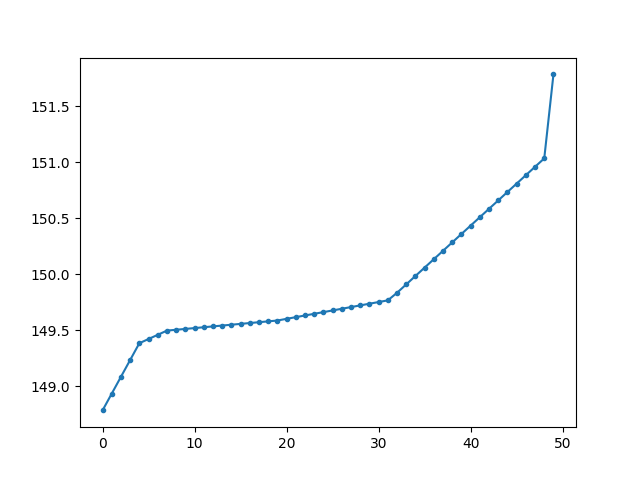

0.0


array([148.78500131, 148.93499821, 149.08500036, 149.23500261,
       149.38500236, 149.42250076, 149.45999736, 149.49750041,
       149.50499973, 149.51250335, 149.51999952, 149.52749844,
       149.53499901, 149.54249853, 149.55000384, 149.55749847,
       149.56500014, 149.57249961, 149.57999728, 149.5874976 ,
       149.60250033, 149.61749828, 149.63250396, 149.6474996 ,
       149.66249759, 149.67750073, 149.69250002, 149.70749701,
       149.72249855, 149.73749724, 149.75249938, 149.76749722,
       149.8349977 , 149.9099986 , 149.9849996 , 150.0599972 ,
       150.13500035, 150.2099996 , 150.2850004 , 150.35999925,
       150.43500215, 150.5100004 , 150.58500005, 150.660001  ,
       150.73499995, 150.80999835, 150.8850011 , 150.95999865,
       151.0350008 , 151.7850025 ])

In [11]:
plt.figure()
plt.plot(Position_mm, label="FEL+Laser",marker='.')
print(np.mean(Palm_fs))
Position_mm

0.7151532557011623
(1755,)


<IPython.core.display.Javascript object>


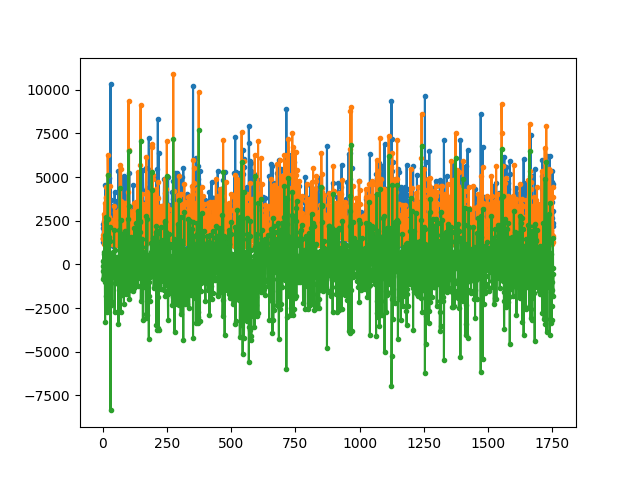

33.2127105018194


In [12]:
print (signal_pump_loop.mean())
print (signal_unpump_loop.shape)
plt.figure()

plt.plot(Izero_pump_loop, label="FEL+Laser",marker='.')
plt.plot(Izero_unpump_loop, label="FEL+Laser",marker='.')
plt.plot(Izero_unpump_loop-Izero_pump_loop, label="FEL+Laser",marker='.')

print (Izero_pump_loop.mean()- Izero_unpump_loop.mean())

<IPython.core.display.Javascript object>


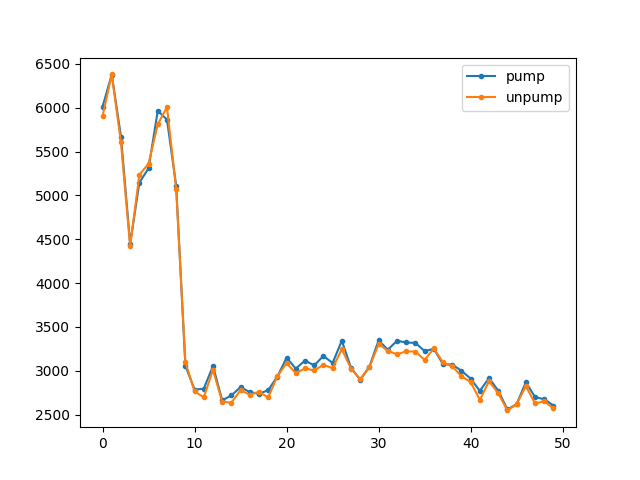

3431.167536189863 3392.574438942524


In [13]:
plt.figure()

plt.plot(Izero_pump_check, label="pump",marker='.')
plt.plot(Izero_unpump_check, label="unpump",marker='.')
print (Izero_pump_check.mean(),Izero_unpump_check.mean())
plt.legend(loc="best")

In [14]:
Signal_pump_norm = Signal_pump #/ Izero_pump
Signal_unpump_norm = Signal_unpump #/ Izero_unpump

SignalT_pump_norm = SignalT_pump #/ Izero_pump
SignalT_unpump_norm = SignalT_unpump #/ Izero_unpump

#Signal_pump_norm = np.log(-(Signal_pump / Izero_pump))
#Signal_unpump_norm = np.log(-(Signal_unpump / Izero_unpump))


#Signal_pump = Signal_pump 
#Signal_unpump_norm = Signal_unpump 

err_signal_pump_norm = err_signal_pump #/ Izero_pump
err_signal_unpump_norm = err_signal_unpump #/ Izero_unpump

#err_signal_pump_relative_norm = err_signal_pump_relative / Izero_pump
#err_signal_unpump_relative_norm = err_signal_unpump_relative / Izero_unpump

#err_signalT_norm = err_signalT_pump / Izero_pump

np.savetxt(scan_name + '.data', (Delay_ps, Signal_pump_norm-Signal_unpump_norm), delimiter=',')

In [18]:
print(Signal_pump_norm-Signal_unpump_norm)

[-9.49959690e-07 -6.57073955e-07 -3.54476756e-07 -2.31709624e-06
 -6.82404813e-07 -5.21825760e-07  2.34319616e-07 -1.21600582e-07
  9.90881963e-07  4.01092669e-06  2.82968741e-06  1.62210069e-06
  8.02108056e-07  2.20668145e-06  5.82452446e-07  3.32489866e-06
  1.00761792e-06  3.67107473e-06  3.94859867e-06 -3.00648690e-08
  4.57069741e-07  2.29573026e-06  1.42508557e-06  2.54561287e-06
  6.03561885e-07  9.00080386e-07  1.87505625e-06 -1.44987349e-07
  2.17829988e-06  1.07184040e-07 -2.92573929e-07  1.45908491e-06
 -2.19063247e-06 -5.20088004e-07 -1.07480521e-06 -1.67526646e-07
 -2.46719053e-06  7.75762232e-07 -7.04424462e-07 -1.55264796e-06
 -2.96997476e-06 -2.26853334e-06 -2.14769942e-06  2.04255598e-06
  2.63533997e-06  1.48965126e-07]


In [96]:
# Optional to run --> it returns the maximum value of the trace
#m=max(Signal_pump_norm-Signal_unpump_norm)
#print(m)
#[i for i, j in enumerate(Signal_pump_norm-Signal_unpump_norm) if j==m] # returns the location in x axis indexes of the max
#print(Energy_eV[15])
#print(Position_mm)

# Plot Energy Scans

<IPython.core.display.Javascript object>


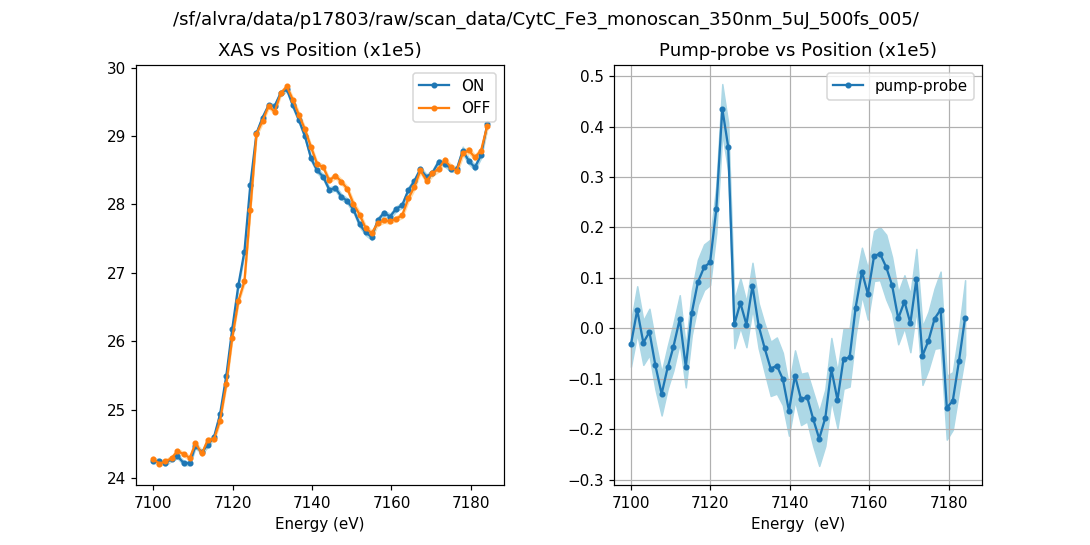

<IPython.core.display.Javascript object>


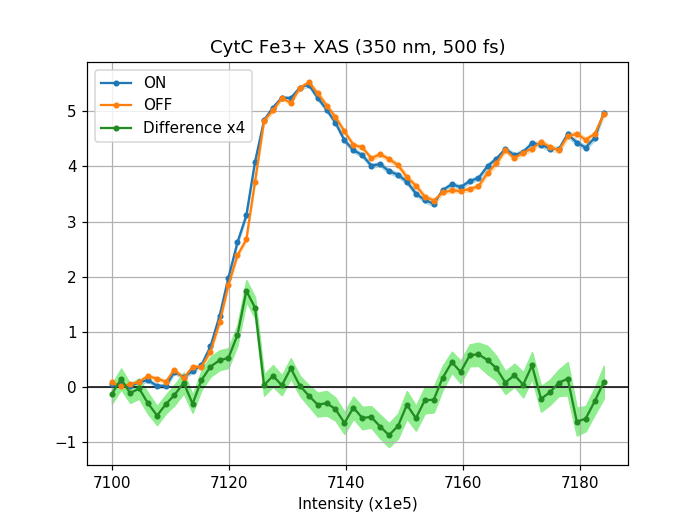

In [100]:
plt.figure(figsize = (10,5))
plt.suptitle(DIR, fontsize=12)
scale=1e5
#plt.title(DIR,horizontalalignment='right')
low_err_pump= Signal_pump_norm - err_signal_pump_norm
high_err_pump= Signal_pump_norm + err_signal_pump_norm
low_err_unpump= Signal_unpump_norm - err_signal_unpump_norm
high_err_unpump= Signal_unpump_norm + err_signal_unpump_norm

#low_err_diff= Signal_pump_norm-Signal_unpump_norm-0.01*np.sqrt(low_err_pump**2 + low_err_unpump**2)
#high_err_diff= Signal_pump_norm-Signal_unpump_norm+0.01*np.sqrt(high_err_pump**2 + high_err_unpump**2)

#low_err_diff= (Signal_pump_norm-Signal_unpump_norm) - err_signal_pump_relative_norm
#high_err_diff= (Signal_pump_norm-Signal_unpump_norm) + err_signal_unpump_relative_norm

low_err_diff= (Signal_pump_norm-Signal_unpump_norm) - np.sqrt(err_signal_pump_norm**2+err_signal_unpump_norm**2)
high_err_diff= (Signal_pump_norm-Signal_unpump_norm) + np.sqrt(err_signal_pump_norm**2+err_signal_unpump_norm**2)

plt.subplot(1,2,1)
plt.plot(Energy_eV, scale*Signal_pump_norm, label="ON",marker='.')
plt.plot(Energy_eV, scale*Signal_unpump_norm, label="OFF",marker='.')
plt.fill_between(Energy_eV, scale*low_err_pump, scale*high_err_pump, color='lightblue')
plt.fill_between(Energy_eV, scale*low_err_unpump, scale*high_err_unpump, color='navajowhite')
plt.xlabel("Energy (eV)")
plt.gca().set_title('XAS vs Position (x1e5)')
plt.legend(loc="best")

plt.subplot(1,2,2)
plt.plot(Energy_eV, scale*(Signal_pump_norm-Signal_unpump_norm), label="pump-probe",marker='.')
plt.fill_between(Energy_eV, scale*low_err_diff, scale*high_err_diff, color='lightblue')
plt.grid()
plt.xlabel("Energy  (eV)")
plt.gca().set_title('Pump-probe vs Position (x1e5)')
plt.legend(loc="best")
#plt.plot(Position_mm, [-0.00000005]*len(Energy_eV) , label="OFF")



#plt.xlabel("Energy (eV)")
plt.legend(loc="best")
plt.subplots_adjust(wspace = 0.3,hspace = 0.5) 

plt.show()

#plt.savefig('Timescan_7_diode')

plt.figure()
plt.axhline(y=0, color='k', linestyle='-', linewidth=1)
plt.plot(Energy_eV, scale*Signal_pump_norm-24.2, label="ON",marker='.')
plt.plot(Energy_eV, scale*Signal_unpump_norm-24.2, label="OFF",marker='.')
plt.fill_between(Energy_eV, scale*low_err_pump-24.2, scale*high_err_pump-24.2, color='lightblue')
plt.fill_between(Energy_eV, scale*low_err_unpump-24.2, scale*high_err_unpump-24.2, color='navajowhite')
plt.xlabel("Energy (eV)")
plt.xlabel("Intensity (x1e5)")
plt.gca().set_title('CytC Fe3+ XAS (350 nm, 500 fs)')
plt.legend(loc="best")
plt.plot(Energy_eV, 4*scale*(Signal_pump_norm-Signal_unpump_norm), label="Difference x4", color='forestgreen',marker='.')
plt.fill_between(Energy_eV, 4*scale*low_err_diff, 4*scale*high_err_diff, color='lightgreen')
plt.legend(loc='upper left')
plt.grid()



In [ ]:
h5f.close()

In [ ]:
#### This is to save h5 data ####

XAS_diff=Signal_pump_norm-Signal_unpump_norm

savedir = "/das/work/p17/p17803/Processed_files/"

h5f = h5py.File(savedir + 'monoscan_5_500fs_CytCFe3','w') 
#h5f = h5py.File(savedir + 'timeScan_4.h5','w')     
#h5f = h5py.File(savedir + 'RIXS_144.h5','w')

h5f.create_dataset('Energy', data = Energy_eV)
#h5f.create_dataset('Energy_BS', data = Energy_eV)
h5f.create_dataset('Signal', data = XAS_diff)
#h5f.create_dataset('Err_XAS_transient', data = Error_XAS_roi1)
# h5f.create_dataset('RIXS_unpumped', data = RIXS_unpumped_roi1)
# #h5f.create_dataset('Err_RIXS_unpumped', data = Error_unpumped_roi1)
# h5f.create_dataset('RIXS_pumped', data = RIXS_pumped_roi1)
# h5f.create_dataset('RIXS_transient', data = RIXS_transient_roi1)
# #h5f.create_dataset('Err_RIXS_transient', data = Error_transient_roi1)

h5f.close()

# Plot Time Scans

<IPython.core.display.Javascript object>


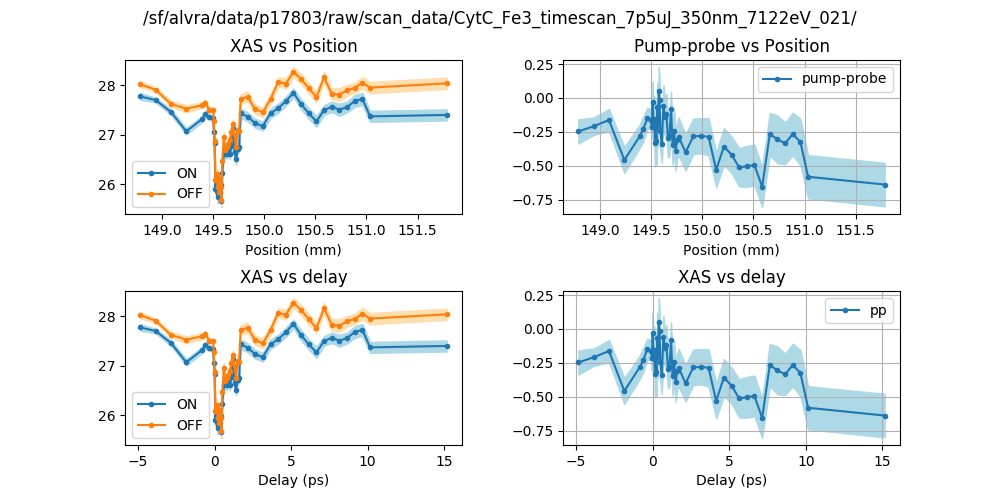

In [15]:
plt.figure(figsize = (10,5))
plt.suptitle(DIR, fontsize=12)
scale=1e5
#plt.title(DIR,horizontalalignment='right')
low_err_pump= Signal_pump_norm - err_signal_pump_norm
high_err_pump= Signal_pump_norm + err_signal_pump_norm
low_err_unpump= Signal_unpump_norm - err_signal_unpump_norm
high_err_unpump= Signal_unpump_norm + err_signal_unpump_norm

#low_err_diff= Signal_pump_norm-Signal_unpump_norm-0.01*np.sqrt(low_err_pump**2 + low_err_unpump**2)
#high_err_diff= Signal_pump_norm-Signal_unpump_norm+0.01*np.sqrt(high_err_pump**2 + high_err_unpump**2)

low_err_diff= (Signal_pump_norm-Signal_unpump_norm) - np.sqrt(err_signal_pump_norm**2+err_signal_unpump_norm**2)
high_err_diff= (Signal_pump_norm-Signal_unpump_norm) + np.sqrt(err_signal_pump_norm**2+err_signal_unpump_norm**2)

XAS_diff=Signal_pump_norm-Signal_unpump_norm


plt.subplot(2,2,1)
plt.plot(Position_mm, scale*Signal_pump_norm, label="ON",marker='.')
plt.plot(Position_mm, scale*Signal_unpump_norm, label="OFF",marker='.')
plt.fill_between(Position_mm, scale*low_err_pump, scale*high_err_pump, color='lightblue')
plt.fill_between(Position_mm, scale*low_err_unpump, scale*high_err_unpump, color='navajowhite')
plt.xlabel("Position (mm)")
plt.gca().set_title('XAS vs Position')
plt.legend(loc="best")

plt.subplot(2,2,2)
plt.plot(Position_mm, scale*(Signal_pump_norm-Signal_unpump_norm), label="pump-probe",marker='.')
plt.fill_between(Position_mm, scale*low_err_diff, scale*high_err_diff, color='lightblue')
plt.grid()
plt.xlabel("Position (mm)")
plt.gca().set_title('Pump-probe vs Position')
plt.legend(loc="best")
#plt.plot(Position_mm, [-0.00000005]*len(Energy_eV) , label="OFF")

plt.subplot(2,2,3)
plt.plot(Delay_ps, scale*Signal_pump_norm, label="ON",marker='.')
plt.plot(Delay_ps, scale*Signal_unpump_norm, label="OFF",marker='.')
plt.fill_between(Delay_ps, scale*low_err_pump, scale*high_err_pump, color='lightblue')
plt.fill_between(Delay_ps, scale*low_err_unpump, scale*high_err_unpump, color='navajowhite')
plt.xlabel("Delay (ps)")
plt.gca().set_title('XAS vs delay')
plt.legend(loc="best")

plt.subplot(2,2,4)
plt.plot(Delay_ps, scale*XAS_diff, label="pp",marker='.')
plt.fill_between(Delay_ps, scale*low_err_diff, scale*high_err_diff, color='lightblue')
plt.grid()
plt.xlabel("Delay (ps)")
plt.gca().set_title('XAS vs delay')


#plt.xlabel("Energy (eV)")
plt.legend(loc="best")
plt.subplots_adjust(wspace = 0.3,hspace = 0.5) 
plt.show()

# save the pp sig and its xaxis into a variable name after the scan name. 
# This is convenient to compare different scans together, see cell below.
x = scan_name + "_DIFF"
t = scan_name + "_DELAY"
vars()[x] = (Signal_pump_norm-Signal_unpump_norm)
vars()[t] = Delay_ps

#plt.savefig('Timescan_7_diode')

np.savetxt(scan_name + '.data', (Delay_ps, Signal_pump_norm-Signal_unpump_norm), delimiter=',')

#np.savetxt(scan_name + '.data', zip(Delay_ps, Signal_pump_norm-Signal_unpump_norm), fmt="%i %5.2f")


In [ ]:
# # Now fit with error function (defined above)
# Signal_norm = Signal_pump_norm-Signal_unpump_norm
# parameters,extras = curve_fit(errfunc, Position_mm, Signal_norm, p0 = [0, 0.1, 149.48, 0.05]) # [baseline, step amplitude, center, FWHM]

# print("Position t0 =",np.abs(np.round(parameters[2],3)),"mm")
# print("Width =",np.abs(np.round(parameters[3],3)),"mm")

In [ ]:
# #... and the plot with the fit curve

# #savedir = "/das/work/p17/p17569/Beamline/"

# plt.figure()

# plt.plot(Position_mm, Signal_norm, label="scan_006",marker='.')
# plt.plot(Position_mm, errfunc(Position_mm,*parameters))

# #low_err= Signal_norm - err_signal_norm
# #high_err= Signal_norm + err_signal_norm
# #plt.fill_between(Position_mm, low_err, high_err, color='lightblue')

# plt.title(np.round(parameters[3], 3) )
# plt.grid()
# plt.xlabel("Delay (mm)")
# plt.legend(loc="best")
# plt.show()
# #plt.savefig(savedir + 'scan_LAM_003')

# Compare runs

In [ ]:
# xaxis4=CytC_Fe3_timescan_5uJ_288nm_7122eV_006_DELAY
# yaxis4=CytC_Fe3_timescan_5uJ_288nm_7122eV_006_DIFF

<IPython.core.display.Javascript object>


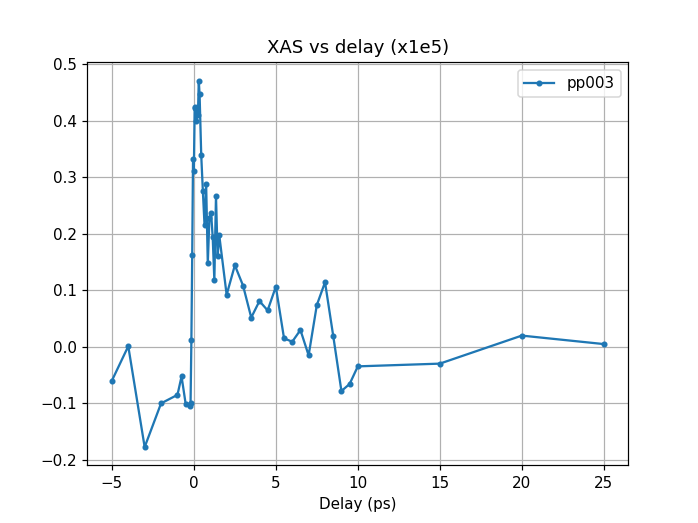

In [26]:
# you have to run the analysis once and the data will be saved in variables scan_name_DELAY and scan_name_DIFF

xaxis1=CytC_Fe3_timescan_7p5uJ_350nm_7122eV_016_DELAY
yaxis1=CytC_Fe3_timescan_7p5uJ_350nm_7122eV_016_DIFF

# xaxis2=CytC_Fe3_timescan_5uJ_288nm_7122eV_004_DELAY
# yaxis2=CytC_Fe3_timescan_5uJ_288nm_7122eV_004_DIFF

# xaxis3=CytC_Fe3_timescan_5uJ_288nm_7122eV_005_DELAY
# yaxis3=CytC_Fe3_timescan_5uJ_288nm_7122eV_005_DIFF

# xaxis4=CytC_Fe3_timescan_5uJ_288nm_7122eV_006_DELAY
# yaxis4=CytC_Fe3_timescan_5uJ_288nm_7122eV_006_DIFF

# xaxis2SORTED = sorted(xaxis2)
# sortindices2=np.argsort(xaxis2)
# yaxis2original=yaxis2
# yaxis2=yaxis2[sortindices2]
#yaxisMODEL = biexp(x,-0.05, 0.1, 0, 0.5, 1, 2., 1, 10.)

plt.figure()
plt.plot(xaxis1, scale*yaxis1, label="pp003",marker='.')
# plt.plot(xaxis2, scale*yaxis2, label="pp004",marker='.')
# plt.plot(xaxis3, scale*yaxis3, label="pp005",marker='.')
# plt.plot(xaxis4, scale*yaxis4, label="pp006",marker='.')
plt.grid()
plt.xlabel("Delay (ps)")
plt.gca().set_title('XAS vs delay (x1e5)')
plt.legend(loc="best")
plt.show()

In [28]:
h5f.close()

In [29]:
XAS_diff=Signal_pump_norm-Signal_unpump_norm

savedir = "/das/work/p17/p17803/Processed_files/"

h5f = h5py.File(savedir + 'timescan_16_7122eV_CytCFe3','w') 
#h5f = h5py.File(savedir + 'timeScan_4.h5','w')     
#h5f = h5py.File(savedir + 'RIXS_144.h5','w')

h5f.create_dataset('Delay', data = xaxis1)
#h5f.create_dataset('Energy_BS', data = Energy_eV)
h5f.create_dataset('XAS', data = XAS_diff)

<HDF5 dataset "XAS": shape (52,), type "<f8">

In [ ]:
# def exp(x, baseline, amplitude, t0, width, a1, t1):
#     return baseline + amplitude*(1-erf((t0-x)*np.sqrt(np.log(2))/(np.abs(width))))*(a1*np.exp(-x/t1))


# # FIT WITH MONO EXPONENTIAL

# parameters1,extras = curve_fit(exp, xaxis1, scale*yaxis1, p0 = [0.01, 0.5, -2, 0.5, 1, 1.]) # [baseline, step amplitude, center, FWHM]

# print("Parameters for interpolated data")
# print("Position t0 =",np.abs(np.round(parameters1[2],3)),"ps")
# print("Width =",np.abs(np.round(parameters1[3],3)),"ps")
# print("a1 =",np.abs(np.round(parameters1[4],3)))
# print("t1 =",np.abs(np.round(parameters1[5],3)),"ps")


# # Fit of the time traces
# plt.figure()
# plt.plot(xaxis1, scale*yaxis1, label="scan_005",marker='.')
# plt.plot(xaxis1, exp(xaxis1,parameters1[0],parameters1[1],parameters1[2],parameters1[3],parameters1[4],\
#                        parameters1[5]))
# plt.legend(loc="best")
# plt.grid()

# plt.xlabel("Delay (ps)")
# plt.legend(loc="best")
# plt.subplots_adjust(wspace = 0.5,hspace = 0.3) 
# plt.show()

Parameters for scan: CytC_Fe3_timescan_5uJ_288nm_7122eV_003
Position t0 = 0.081 ps
Width = 0.088 ps
a1 = 0.751
t1 = 1.417 ps
a2 = 0.175
t2 = 99307.779 ps


/sf/alvra/anaconda/4.4.0/lib/python3.6/site-packages/ipykernel/__main__.py:27: RuntimeWarning: overflow encountered in exp


<IPython.core.display.Javascript object>


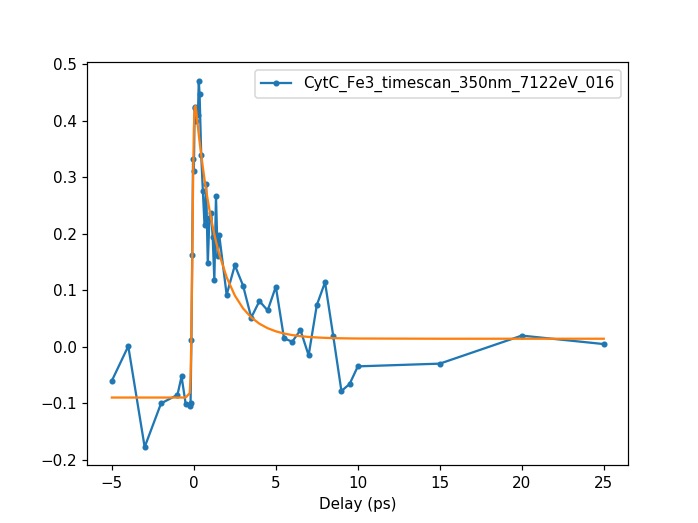

In [15]:
# Fit of the time traces
parameters1,extras = curve_fit(biexp, xaxis1, scale*yaxis1, p0 = [5, 0.5, -2, 0.9, 3, 1., 0.2, 30]) # [baseline, step amplitude, center, FWHM]
# parameters2,extras = curve_fit(biexp, xaxis2, scale*yaxis2, p0 = [-0.05, -0.1, -3, 0.5, 1, 1., 1., 5.]) # [baseline, step amplitude, center, FWHM]
# parameters3,extras = curve_fit(biexp, xaxis3, scale*yaxis3, p0 = [-0.0, -0.2, 0, 0.1, 1, 1., 1., 5.]) # [baseline, step amplitude, center, FWHM]
# parameters4,extras = curve_fit(biexp, xaxis4, scale*yaxis4, p0 = [-0.0, -0.2, 0, 0.1, 1, 1., 1., 5.]) # [baseline, step amplitude, center, FWHM]


print("Parameters for scan: CytC_Fe3_timescan_5uJ_288nm_7122eV_003")
print("Position t0 =",np.abs(np.round(parameters1[2],3)),"ps")
print("Width =",np.abs(np.round(parameters1[3],3)),"ps")
print("a1 =",np.abs(np.round(parameters1[4],3)))
print("t1 =",np.abs(np.round(parameters1[5],3)),"ps")
print("a2 =",np.abs(np.round(parameters1[6],3)))
print("t2 =",np.abs(np.round(parameters1[7],3)),"ps")

# print("Parameters for scan: CytC_Fe3_timescan_5uJ_288nm_7122eV_004")
# print("Position t0 =",np.abs(np.round(parameters2[2],3)),"ps")
# print("Width =",np.abs(np.round(parameters2[3],3)),"ps")
# print("a1 =",np.abs(np.round(parameters2[4],3)))
# print("t1 =",np.abs(np.round(parameters2[5],3)),"ps")
# print("a2 =",np.abs(np.round(parameters2[6],3)))
# print("t2 =",np.abs(np.round(parameters2[7],3)),"ps")

# print("Parameters for scan: CytC_Fe3_timescan_5uJ_288nm_7122eV_005")
# print("Position t0 =",np.abs(np.round(parameters3[2],3)),"ps")
# print("Width =",np.abs(np.round(parameters3[3],3)),"ps")
# print("a1 =",np.abs(np.round(parameters3[4],3)))
# print("t1 =",np.abs(np.round(parameters3[5],3)),"ps")
# print("a2 =",np.abs(np.round(parameters3[6],3)))
# print("t2 =",np.abs(np.round(parameters3[7],3)),"ps")

# print("Parameters for scan: CytC_Fe3_timescan_5uJ_288nm_7122eV_006")
# print("Position t0 =",np.abs(np.round(parameters4[2],3)),"ps")
# print("Width =",np.abs(np.round(parameters4[3],3)),"ps")
# print("a1 =",np.abs(np.round(parameters4[4],3)))
# print("t1 =",np.abs(np.round(parameters4[5],3)),"ps")
# print("a2 =",np.abs(np.round(parameters4[6],3)))
# print("t2 =",np.abs(np.round(parameters4[7],3)),"ps")
newy1=scale*yaxis1

plt.figure()
plt.plot(xaxis1, newy1, label="CytC_Fe3_timescan_350nm_7122eV_016",marker='.')
plt.plot(xaxis1, biexp(xaxis1,parameters1[0],parameters1[1],parameters1[2],parameters1[3],parameters1[4],\
                       parameters1[5],parameters1[6],parameters1[7]))
plt.legend(loc="best")
plt.grid()

            
# plt.figure()
# plt.grid()
# plt.subplot(4,1,1)
# plt.plot(xaxis1, scale*yaxis1, label="scan_003",marker='.')
# plt.plot(xaxis1, biexp(xaxis1,parameters1[0],parameters1[1],parameters1[2],parameters1[3],parameters1[4],\
#                        parameters1[5],parameters1[6],parameters1[7]))
# plt.legend(loc="best")

# plt.grid()
# plt.subplot(4,1,2)
# plt.plot(xaxis2, scale*yaxis2, label="scan_004",marker='.')
# plt.plot(xaxis2, biexp(xaxis2,parameters2[0],parameters2[1],parameters2[2],parameters2[3],parameters2[4],\
#                        parameters2[5],parameters2[6],parameters2[7]))
# plt.legend(loc="best")

# plt.grid()
# plt.subplot(4,1,3)
# plt.plot(xaxis3, scale*yaxis3, label="scan_005",marker='.')
# plt.plot(xaxis3, biexp(xaxis3,parameters3[0],parameters3[1],parameters3[2],parameters3[3],parameters3[4],\
#                        parameters3[5],parameters3[6],parameters3[7]))
# plt.legend(loc="best")

# plt.grid()
# plt.subplot(4,1,4)
# plt.plot(xaxis4, scale*yaxis4, label="scan_006",marker='.')
# plt.plot(xaxis4, biexp(xaxis4,parameters4[0],parameters4[1],parameters4[2],parameters4[3],parameters4[4],\
#                        parameters4[5],parameters4[6],parameters4[7]))
plt.grid()
plt.xlabel("Delay (ps)")
plt.legend(loc="best")
plt.subplots_adjust(wspace = 0.5,hspace = 0.3) 
plt.show()


# Other plots.

#plt.plot(xaxis1 - parameters1[2], biexp(xaxis1 - parameters1[2],parameters1[0],parameters1[1],\
#                 parameters1[2],parameters1[3],parameters1[4],parameters1[5],parameters1[6],parameters1[7]))
#plt.plot(xaxis2 - parameters2[2], biexp(xaxis2 - parameters2[2],parameters2[0],parameters2[1],parameters2[2],\
#                 parameters2[3],parameters2[4],parameters2[5],parameters2[6],parameters2[7]))



#plt.plot(xaxis1 - parameters1[2], yaxis1, label="scan_003",marker='.')
#plt.plot(xaxis2 - parameters2[2], yaxis2, label="scan_004",marker='.')

fitfct=biexp(xaxis1,parameters1[0],parameters1[1],parameters1[2],parameters1[3],parameters1[4],\
                       parameters1[5],parameters1[6],parameters1[7])


In [16]:
h5f.close()

In [17]:
#### This is to save h5 data ####

XAS_diff=Signal_pump_norm-Signal_unpump_norm

savedir = "/das/work/p17/p17803/Processed_files/"

h5f = h5py.File(savedir + 'timescan_16_7122eV_CytCFe3','w') 
#h5f = h5py.File(savedir + 'timeScan_4.h5','w')     
#h5f = h5py.File(savedir + 'RIXS_144.h5','w')

h5f.create_dataset('Delay', data = xaxis1)
#h5f.create_dataset('Energy_BS', data = Energy_eV)
h5f.create_dataset('XAS', data = newy1)
# h5f.create_dataset('Fit', data = fitfct)
#h5f.create_dataset('Err_XAS_transient', data = Error_XAS_roi1)
# h5f.create_dataset('RIXS_unpumped', data = RIXS_unpumped_roi1)
# #h5f.create_dataset('Err_RIXS_unpumped', data = Error_unpumped_roi1)
# h5f.create_dataset('RIXS_pumped', data = RIXS_pumped_roi1)
# h5f.create_dataset('RIXS_transient', data = RIXS_transient_roi1)
# #h5f.create_dataset('Err_RIXS_transient', data = Error_transient_roi1)

<HDF5 dataset "Fit": shape (52,), type "<f8">

In [ ]:
xaxis1_corr=xaxis1-parameters1[2]
yaxis1=CytC_Fe3_timescan_5uJ_288nm_7122eV_003_DIFF

xaxis2_corr=xaxis2-parameters2[2]
yaxis2=CytC_Fe3_timescan_5uJ_288nm_7122eV_004_DIFF

xaxis3_corr=xaxis3-parameters3[2]
yaxis3=CytC_Fe3_timescan_5uJ_288nm_7122eV_005_DIFF

xaxis4_corr=xaxis4-parameters4[2]
yaxis4=CytC_Fe3_timescan_5uJ_288nm_7122eV_006_DIFF



plt.figure()
plt.grid()
plt.subplot(4,1,1)
plt.plot(xaxis1_corr, scale*yaxis1, label="scan_003",marker='.')
plt.plot(xaxis1, biexp(xaxis1,parameters1[0],parameters1[1],parameters1[2],parameters1[3],parameters1[4],\
                       parameters1[5],parameters1[6],parameters1[7]))
plt.legend(loc="best")

plt.grid()
plt.subplot(4,1,2)
plt.plot(xaxis2_corr, scale*yaxis2, label="scan_004",marker='.')
plt.plot(xaxis2, biexp(xaxis2,parameters2[0],parameters2[1],parameters2[2],parameters2[3],parameters2[4],\
                       parameters2[5],parameters2[6],parameters2[7]))
plt.legend(loc="best")

plt.grid()
plt.subplot(4,1,3)
plt.plot(xaxis3_corr, scale*yaxis3, label="scan_005",marker='.')
plt.plot(xaxis3, biexp(xaxis3,parameters3[0],parameters3[1],parameters3[2],parameters3[3],parameters3[4],\
                       parameters3[5],parameters3[6],parameters3[7]))
plt.legend(loc="best")

plt.grid()
plt.subplot(4,1,4)
plt.plot(xaxis4_corr, scale*yaxis4, label="scan_006",marker='.')
plt.plot(xaxis4, biexp(xaxis4,parameters4[0],parameters4[1],parameters4[2],parameters4[3],parameters4[4],\
                       parameters4[5],parameters4[6],parameters4[7]))
plt.grid()
plt.xlabel("Delay (ps)")
plt.legend(loc="best")
plt.subplots_adjust(wspace = 0.5,hspace = 0.3) 
plt.show()


# Other plots.

#plt.plot(xaxis1 - parameters1[2], biexp(xaxis1 - parameters1[2],parameters1[0],parameters1[1],\
#                 parameters1[2],parameters1[3],parameters1[4],parameters1[5],parameters1[6],parameters1[7]))
#plt.plot(xaxis2 - parameters2[2], biexp(xaxis2 - parameters2[2],parameters2[0],parameters2[1],parameters2[2],\
#                 parameters2[3],parameters2[4],parameters2[5],parameters2[6],parameters2[7]))



#plt.plot(xaxis1 - parameters1[2], yaxis1, label="scan_003",marker='.')
#plt.plot(xaxis2 - parameters2[2], yaxis2, label="scan_004",marker='.')



# Corrects for the t0 (according to fit)

In [ ]:
xaxis1_corr=xaxis1-parameters1[2]
yaxis1=CytC_Fe3_timescan_5uJ_288nm_7122eV_003_DIFF

xaxis2_corr=xaxis2-parameters2[2]
yaxis2=CytC_Fe3_timescan_5uJ_288nm_7122eV_004_DIFF

xaxis3_corr=xaxis3-parameters3[2]
yaxis3=CytC_Fe3_timescan_5uJ_288nm_7122eV_005_DIFF

xaxis4_corr=xaxis4-parameters4[2]
yaxis4=CytC_Fe3_timescan_5uJ_288nm_7122eV_006_DIFF



# Interpolates the data and average different runs

In [ ]:
from scipy.interpolate import interp1d
from scipy import interpolate

y1 = yaxis1
x1 = xaxis1_corr
f1 = interp1d(x1, y1, kind='linear')

y2 = yaxis2
x2 = xaxis2_corr
f2 = interp1d(x2, y2, kind='linear')

y3 = yaxis3
x3 = xaxis3_corr
f3 = interp1d(x3, y3, kind='linear')

y4 = yaxis4
x4 = xaxis4_corr
f4 = interp1d(x4, y4, kind='linear')

xnew = np.linspace(-4.5, 9.7, num=500, endpoint=True)
ynew1=f1(xnew)
ynew2=f2(xnew)
ynew3=f3(xnew)
ynew4=f4(xnew)


plt.figure()
plt.plot(xnew, ynew4, '-')
plt.plot(x4, y4, 'x')


#Spline -- not working yet
#tck = interpolate.splrep(x, y, s=0)
#ynew = interpolate.splev(xnew, tck, der=0)

ynew1_norm=ynew1/np.max(ynew1)
ynew2_norm=ynew2/np.max(ynew2)
ynew3_norm=ynew3/np.max(ynew3)
ynew4_norm=ynew4/np.max(ynew4)

y_ave=(ynew1_norm+ynew3_norm+ynew4_norm)/3

#y_ave=(ynew1+ynew3+ynew4)/3



parameters_ave,extras = curve_fit(biexp, xnew, y_ave, p0 = [0.00, 1, 1, 0.1, 0.0001, .5, 5., 20.]) # [baseline, step amplitude, center, FWHM]

print("Parameters for interpolated data")
print("Position t0 =",np.abs(np.round(parameters1[2],3)),"ps")
print("Width =",np.abs(np.round(parameters1[3],3)),"ps")
print("a1 =",np.abs(np.round(parameters1[4],3)))
print("t1 =",np.abs(np.round(parameters1[5],3)),"ps")
print("a2 =",np.abs(np.round(parameters1[6],3)))
print("t2 =",np.abs(np.round(parameters1[7],3)),"ps")



plt.figure()
plt.plot(xnew,y_ave, '-')

plt.plot(xnew, biexp(xnew,parameters_ave[0],parameters_ave[1],parameters_ave[2],parameters_ave[3],parameters_ave[4],\
                       parameters_ave[5],parameters_ave[6],parameters_ave[7]))
#plt.plot(x1, y1, 'x')
#plt.plot(x4, y4, 'x')
#plt.plot(x2, y2, 'x')
#plt.plot(x3, y3, 'x')


# More stuff

In [ ]:
myList = np.concatenate((np.arange(7100,7105,1), np.arange(7105,7120,0.5), np.arange(7120,7160,1),np.arange(7160,7200,3)))

In [ ]:
time_zero = 150.188         #this is in mm from the delay scans

desidered_delays = [-10,-1,1]  
#choose this in ps

delay_to_set = (100/(2*333))*desidered_delay + time_zero        #factor of 2 because of the delay stage

desidered_delay + time_zero
print ("To be at",desidered_delay,"ps, put the laser pump delay stage to",np.round(delay_to_set,4),"mm")


T_1 = np.arange(149.4372,150.1872


mtime = np.concatenate((np.arange(149.4372,7105,1), np.arange(7105,7120,0.5), np.arange(7120,7160,1),np.arange(7160,7200,3)))

In [ ]:
print(time_zero)

In [ ]:
desidered_delays = [-10,-1,1]  


In [ ]:
Position_mm

delay_ps = (Position_mm - 150.188)*2/(3e8*1e3*1e-12)
print(delay_ps)

In [ ]:
t0_mm = 149.466
0.5*(3e8*1e3*1e-12)/2 + t0_mm

In [ ]:
t0_mm = 149.466
delaylist=np.concatenate((np.arange(-5.,-1.+1.,1.), np.arange(-0.25,0.3+0.05,0.05), \
                          np.arange(0.35,1.5+0.1,0.1),np.arange(2.,10.+0.5,0.5),[15.,20.,25.]))
position_list = delaylist*(3e8*1e3*1e-12)/2 + t0_mm
print(position_list)
print(delaylist)
len(delaylist)

time = 0.5*(3e8*1e3*1e-12)/2 + t0_mm
print(time)


In [ ]:
mytime = np.concatenate((np.arange(149.4372,150.188,0.15), np.arange(150.1505,150.2255,0.007), np.arange(150.2255,150.3382,0.015), np.arange(150.3382,151.6895,0.0
   ...: 75)))